<a href="https://colab.research.google.com/github/ShabnaIlmi/Data-Science-Group-Project/blob/End_User_Risk_Prediction/PreProcess_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [112]:
# import libraries
from IPython import get_ipython
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from matplotlib.ticker import LogLocator, FuncFormatter
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from datetime import datetime, timedelta
import os
import joblib
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [ ]:
# Mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [113]:
# Loading the dataset with the proper delimiter (semicolon)
data = pd.read_excel('/content/drive/MyDrive/DSGP_User/Pre Processed data/Stock-report_generated.xlsx', sheet_name='TCC')

# Displaying the first few rows of the data
data.head()


,Warehouse,Product code,Invoice No,Transaction Date,UOM,Issued Qty,Customer name
0,B4,H2O2-50%-IG-TCC-BANGLADESH,SI-N/10/24/197,2024-10-11,KG,150.0,PETTAH CHEMICAL
1,B4,H2O2-50%-IG-TCC-BANGLADESH,SI-N/10/24/205,2024-10-11,KG,30.0,PIYARA WASHING ENTERPRISES
2,B4,H2O2-50%-IG-TCC-BANGLADESH,SI-N/10/24/217,2024-10-12,KG,180.0,RIVINTA DRY AND WASHING
3,B4,H2O2-50%-IG-TCC-BANGLADESH,SI-N/10/24/240,2024-10-15,KG,60.0,SN PRODUCTS
4,B4,H2O2-50%-IG-TCC-BANGLADESH,SI-N/10/24/248,2024-10-15,KG,150.0,NEW BRILLIANT WASHING


In [114]:
# Displaying information
print("Displaying data information")
data.info()

Displaying data information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2131 entries, 0 to 2130
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Warehouse         2087 non-null   object        
 1   Product code      2087 non-null   object        
 2   Invoice No        2087 non-null   object        
 3   Transaction Date  2087 non-null   datetime64[ns]
 4   UOM               2087 non-null   object        
 5   Issued Qty        2087 non-null   float64       
 6   Customer name     2087 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 116.7+ KB


In [115]:
# Identifying categorical and numerical columns
categorical_cols = data.select_dtypes(include=['object']).columns
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns

# Displaying the categorical features
print("Categorical Features:")
print(categorical_cols)


Categorical Features:
Index(['Warehouse', 'Product code', 'Invoice No', 'UOM', 'Customer name'], dtype='object')


In [116]:
# Displaying the unique values and their counts relevant to each categorical column
for col in categorical_cols:
    print(f"\nColumn: {col}")
    print(data[col].value_counts(), "\n")


Column: Warehouse
Warehouse
WH-75    1058
B4       1029
Name: count, dtype: int64 


Column: Product code
Product code
Hydrogen Peroxide             138
Hydrochloric Acid             137
Potassium Chloride            136
Potassium Nitrate             135
Ammonia                       133
Dynamite                      131
Potassium Permanganate        131
Sodium Nitrate                127
Benzene                       123
Sulfuric Acid                 120
Ammonium Sulfate              119
Acetone                       118
Trinitrotoluene (TNT)         117
Ethanol                       115
Ammonium Nitrate              114
Nitric Acid                   106
H2O2-50%-IG-TCC-BANGLADESH     40
LC-IG-ISGEC-INDIA              21
H2O2-50%-IG-ICL-BANGLADESH     14
LC-IG-PCIPL-INDIA              12
Name: count, dtype: int64 


Column: Invoice No
Invoice No
SI-N/10/25/614    5
SI-N/10/25/286    5
SI-N/10/25/941    5
SI-N/11/25/809    5
SI-N/10/25/497    5
                 ..
SI-N/11/25/205    1
S

In [117]:
# Displaying the numerical features
print("Numerical Features:")
print(numerical_cols)

Numerical Features:
Index(['Issued Qty '], dtype='object')


In [118]:
# Unique values and their counts relevant to each numerical columns
for col in numerical_cols:
    print(f"\nColumn: {col}")
    print(data[col].value_counts(), "\n")


Column: Issued Qty 
Issued Qty 
900.0     31
1800.0    10
90.0       6
300.0      6
30.0       6
          ..
1462.0     1
2922.0     1
2383.0     1
3335.0     1
983.0      1
Name: count, Length: 1504, dtype: int64 



In [119]:
# Fill missing values in 'Issued Qty' with 0
data['Issued Qty '] = data['Issued Qty '].fillna(0)

In [120]:
# Strip any leading or trailing spaces from column names
data.columns = data.columns.str.strip()

# Convert 'Transaction Date' to datetime if not already done
data['Transaction Date'] = pd.to_datetime(data['Transaction Date'], errors='coerce')

# Define lists of high-risk and hazardous chemicals
HIGH_RISK_CHEMICALS = ['Ammonium Nitrate', 'Trinitrotoluene (TNT)', 'Dynamite', 'Potassium Nitrate', 'Sodium Nitrate']
HAZARDOUS_CHEMICALS = ['Sulfuric Acid', 'Ammonia', 'Hydrochloric Acid', 'Nitric Acid', 'Hydrogen Peroxide',
                       'Acetone', 'Benzene', 'Ethanol', 'Ammonium Sulfate', 'Potassium Chloride', 'Potassium Permanganate']

# Define thresholds
HIGH_USAGE_THRESHOLD = 500  # 500 kg for hazardous chemicals (reduced from 1000 kg)
MEDIUM_USAGE_THRESHOLD = 250  # 250 kg for hazardous chemicals (new threshold)
FREQUENT_PURCHASE_DAYS = 15  # Purchases within 15 days are frequent (reduced from 30 days)
MEDIUM_FREQUENCY_THRESHOLD = 30  # Purchases between 15 and 30 days are medium frequency (new threshold)
NEW_CUSTOMER_THRESHOLD = 60  # Customers with first purchase after 60 days are new (reduced from 90 days)

# Function to calculate days since last transaction for a customer
def days_since_last_transaction(data, customer_name, current_date):
    customer_transactions = data[data['Customer name'] == customer_name]['Transaction Date']
    if not customer_transactions.empty:
        last_transaction_date = customer_transactions.max()
        days_difference = (current_date - last_transaction_date).days
        return days_difference
    else:
        return None

# Function to identify new customers
def is_new_customer(data, customer_name, current_date, threshold_days=NEW_CUSTOMER_THRESHOLD):
    customer_transactions = data[data['Customer name'] == customer_name]['Transaction Date']
    if not customer_transactions.empty:
        first_transaction_date = customer_transactions.min()
        days_since_first = (current_date - first_transaction_date).days
        return days_since_first <= threshold_days
    else:
        return True  # Treat as new if no transaction history

# Define Risk Levels based on the new logic
def assess_risk(row):
    customer = row['Customer name']
    issued_qty = row['Issued Qty']
    transaction_date = row['Transaction Date']
    chemical_description = row['Product code']  # Assuming 'Description' contains the chemical name

    # Initialize risk level as Low
    risk_level = 'Low Risk'

    # High-Risk Chemicals Check
    if chemical_description in HIGH_RISK_CHEMICALS:
        return 'High Risk'  # Automatically High Risk for explosive chemicals

    # High Usage for Hazardous Chemicals Check
    if chemical_description in HAZARDOUS_CHEMICALS:
        if issued_qty > HIGH_USAGE_THRESHOLD:
            risk_level = 'High Risk'
        elif issued_qty > MEDIUM_USAGE_THRESHOLD:
            risk_level = 'Medium Risk'

    # Frequent Purchase Check
    today = pd.Timestamp(datetime.now().date())
    days_since_last = days_since_last_transaction(data, customer, today)
    if days_since_last is not None:
        if days_since_last <= FREQUENT_PURCHASE_DAYS:
            risk_level = 'High Risk'
        elif FREQUENT_PURCHASE_DAYS < days_since_last <= MEDIUM_FREQUENCY_THRESHOLD:
            if risk_level != 'High Risk':  # Don't downgrade from High Risk
                risk_level = 'Medium Risk'

    # New Customer Check
    if is_new_customer(data, customer, today):
        if risk_level != 'High Risk':  # Don't downgrade from High Risk
            risk_level = 'High Risk'

    return risk_level

# Apply the modified risk assessment function
data['Risk Level'] = data.apply(assess_risk, axis=1)

# --- Save the Updated Excel File ---
output_file = '/content/drive/MyDrive/DSGP_User/Pre Processed data/Stock-report_with_risk.xlsx'
data.to_excel(output_file, sheet_name='TCC', index=False)
print(f"Updated data saved to '{output_file}'")

# --- Display Risk Level Counts ---
print("\n--- Risk Level Counts ---")
print(data['Risk Level'].value_counts())

Updated data saved to '/content/drive/MyDrive/DSGP_User/Pre Processed data/Stock-report_with_risk.xlsx'

--- Risk Level Counts ---
Risk Level
High Risk      1881
Low Risk        158
Medium Risk      92
Name: count, dtype: int64


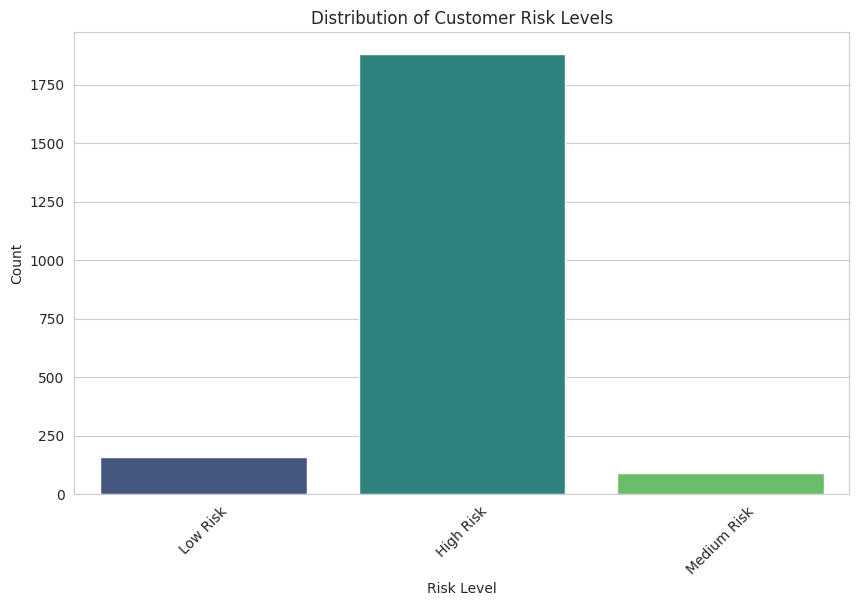

In [121]:
# Visualizing the distribution of the target variable 'Risk Level'
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Risk Level', palette='viridis')
plt.title('Distribution of Customer Risk Levels')
plt.xlabel('Risk Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

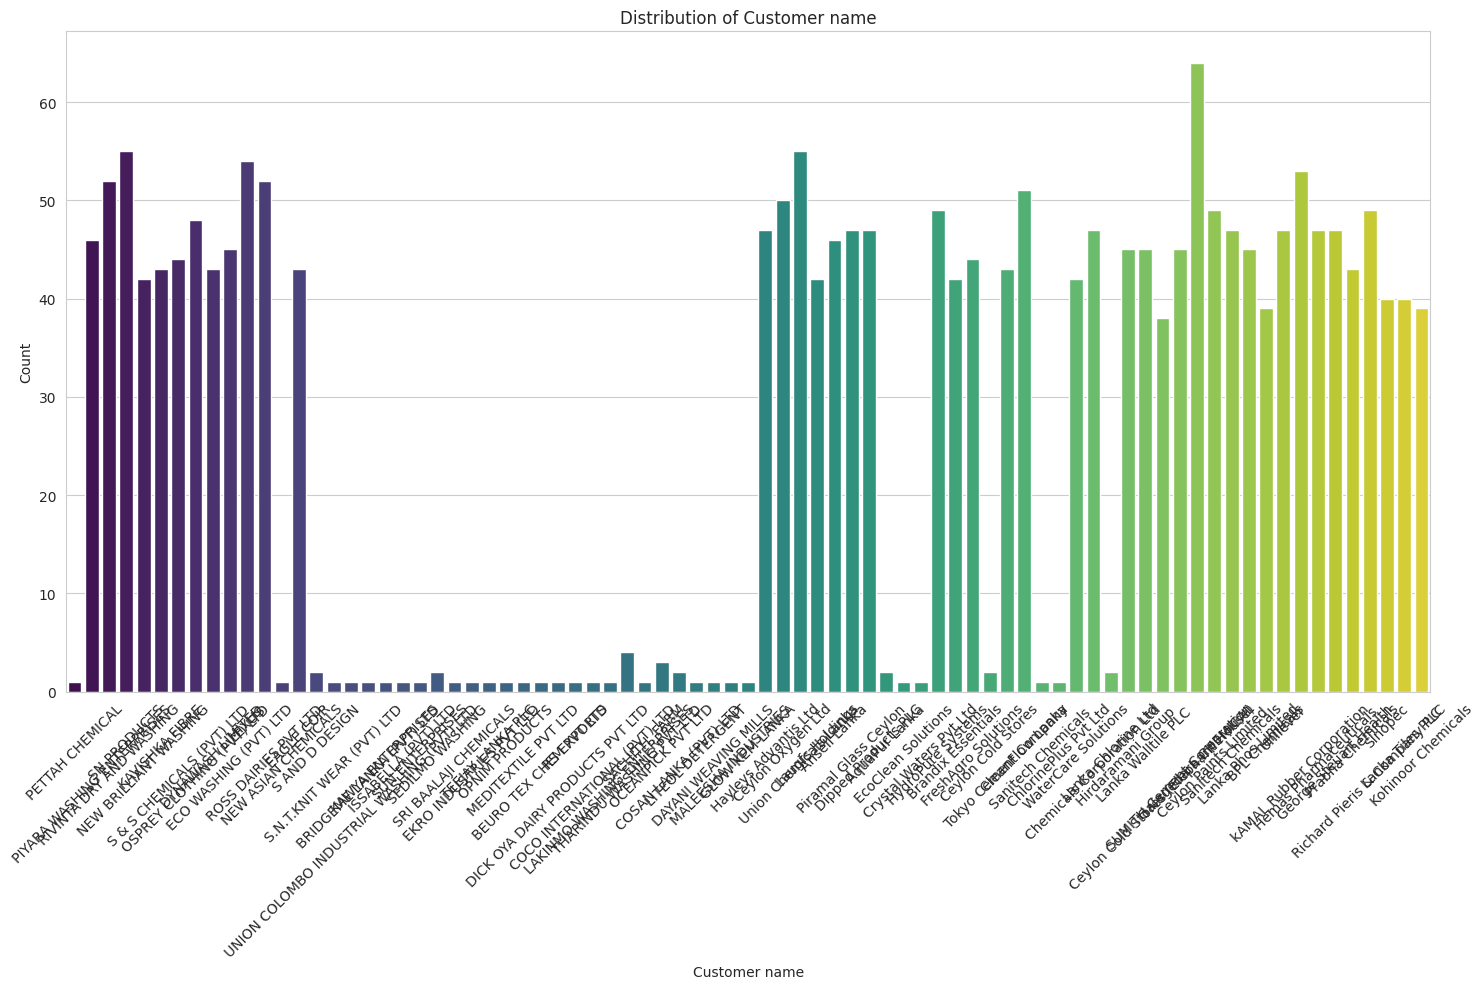

In [122]:
# Defining a list to store the categorical variables
categorical_columns = [ 'Customer name']

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Loop through each categorical column and create a bar plot
for i, column in enumerate(categorical_columns):
    plt.subplot(len(categorical_columns), 1, i + 1)  # Create a subplot for each column
    sns.countplot(data=data, x=column, palette='viridis')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)  # Rotate x labels for better readability

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


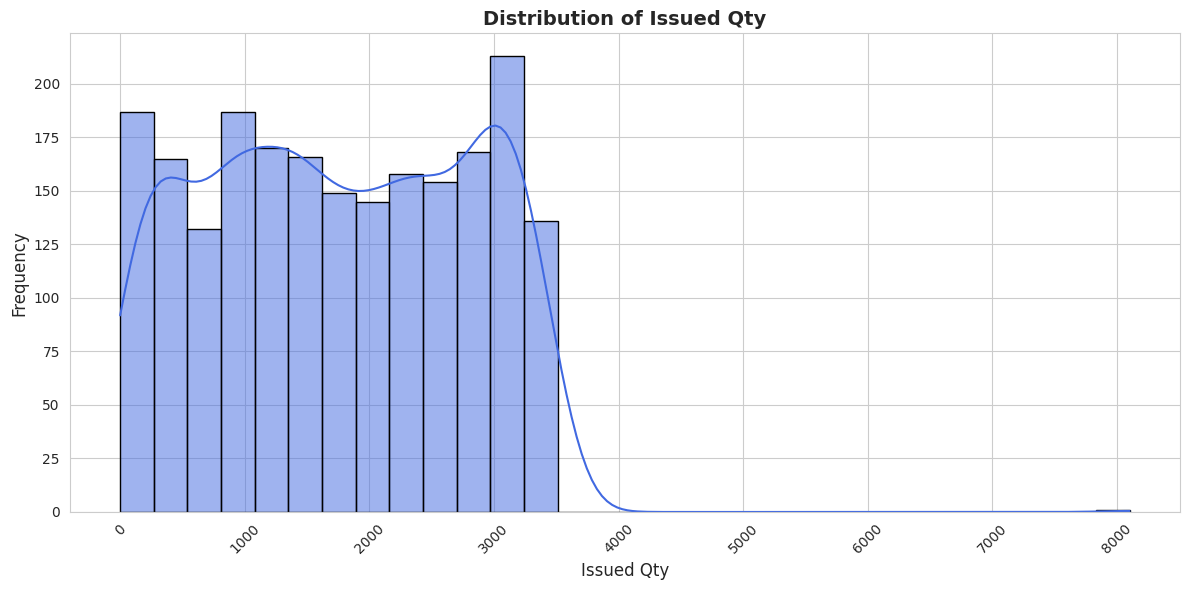

In [123]:
# Defining a list to store the numerical variables
numerical_columns = ['Issued Qty']  # Ensure correct column name

# Set plot style
sns.set_style("whitegrid")

# Set up the matplotlib figure
plt.figure(figsize=(12, 6))  # Adjust figure size for better readability

# Loop through each numerical column and create a bar plot
for i, column in enumerate(numerical_columns):
    plt.subplot(len(numerical_columns), 1, i + 1)  # Create a subplot for each column

    # Use histogram instead of countplot for numerical data
    sns.histplot(data[column], bins=30, kde=True, color="royalblue", edgecolor="black")

    plt.title(f'Distribution of {column}', fontsize=14, fontweight='bold')
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(rotation=45, fontsize=10)  # Rotate x labels for better readability
    plt.yticks(fontsize=10)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [124]:
# Strip any leading or trailing spaces from column names
data.columns = data.columns.str.strip()

# Select numerical columns for outlier detection
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Function to detect outliers using the IQR method
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Check for outliers in each numerical column
outlier_summary = {}
for col in numerical_columns:
    outliers = detect_outliers_iqr(data, col)
    outlier_summary[col] = len(outliers)

# Display the number of outliers for each numerical column
outlier_summary_df = pd.DataFrame(outlier_summary.items(), columns=['Column', 'Number of Outliers'])
print(outlier_summary_df)

       Column  Number of Outliers
0  Issued Qty                   1


#**Data Preprocessing**

---



In [125]:
# Step 1: Removing whitespaces from the object type columns
object_columns = data.select_dtypes(include=['object']).columns
data[object_columns] = data[object_columns].apply(lambda x: x.str.strip())

# Step 2: Identifying and displaying duplicate values
print(f"Initial dataset shape: {data.shape}")

# Identify duplicates
duplicates = data[data.duplicated(keep=False)]  # Keep all duplicates for display
print(f"Number of duplicate rows found: {duplicates.shape[0]}")

# Remove duplicate values
data = data.drop_duplicates()
print(f"Shape after removing duplicates: {data.shape}")

Initial dataset shape: (2131, 8)
Number of duplicate rows found: 44
Shape after removing duplicates: (2088, 8)


In [126]:
# Step 3: Handling missing values in the Categorical Columns

# Checking for missing values in the Categorical Columns
for column in categorical_cols:
    print(f"Missing values for column {column}: {data[column].isnull().sum()}")

Missing values for column Warehouse: 1
Missing values for column Product code: 1
Missing values for column Invoice No: 1
Missing values for column UOM: 1
Missing values for column Customer name: 1


In [127]:
# Step 4: Handling missing values in the Numerical Columns

# Redefine numerical_cols after stripping column names (or after any operation that modifies column names)
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns

# Checking for missing values in the Numerical Columns
for column in numerical_cols:
    print(f"Missing values for column {column}: {data[column].isnull().sum()}")

Missing values for column Issued Qty: 0


In [128]:
# Select numerical columns for outlier detection
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Function to cap outliers using the IQR method
def cap_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap the outliers
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

# Apply capping for outliers in each numerical column
for col in numerical_columns:
    data = cap_outliers_iqr(data, col)

# Display the updated DataFrame with capped outliers
print(data[numerical_columns].describe())

        Issued Qty
count  2088.000000
mean   1782.529514
std    1009.420940
min       0.000000
25%     902.250000
50%    1767.500000
75%    2696.000000
max    5386.625000


In [129]:
# All categorical columns are encoded using the label encoding since the categorical data contained within the dataset are ordinal

# Step 5: Encoding the categorical columns

# Defining the columns to be encoded
encoding_cols = ['Warehouse', 'Product code', 'Invoice No', 'UOM', 'Customer name', 'Risk Level']

# Initialize the LabelEncoder
label_encoders = {}

# Apply label encoding to each categorical column and save the encoder
for column in encoding_cols:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column].astype(str))  # Convert to string to handle NaN values
    label_encoders[column] = le  # Store the encoder for future use

encoder_save_path = '/content/drive/MyDrive/DSGP_User/Pre Processed data/Label_Encoder.pkl'

# Save the model
joblib.dump(label_encoders, encoder_save_path)

print(f"Encoder saved to {encoder_save_path}")

# Display the first few rows of the updated DataFrame
data.head()

Model saved to /content/drive/MyDrive/DSGP_User/Pre Processed data/Label_Encoder.pkl


,Warehouse,Product code,Invoice No,Transaction Date,UOM,Issued Qty,Customer name,Risk Level
0,0,8,36,2024-10-11,0,150.0,51,1
1,0,8,37,2024-10-11,0,30.0,52,1
2,0,8,38,2024-10-12,0,180.0,55,1
3,0,8,39,2024-10-15,0,60.0,64,1
4,0,8,41,2024-10-15,0,150.0,47,1


In [130]:
# Redefine numerical_cols after dropping 'Received Qty'
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns

# Step 5: Scaling the Numerical Features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[numerical_cols])

scaler_save_path = '/content/drive/MyDrive/DSGP_User/Pre Processed data/Standard_Scaler.pkl'

# Save the model
joblib.dump(scaler, scaler_save_path)

# Step 6: Handling the columns with low correlation coefficients with the target column
correlation_with_target = data.corr()['Risk Level'].sort_values(ascending=False)

# Print the correlation values
print("Correlation with Risk Level:")
print(correlation_with_target)

print(f"scaler saved to {scaler_save_path}")

Correlation with Risk Level:
Risk Level          1.000000
Transaction Date    0.005174
UOM                -0.007557
Warehouse          -0.029465
Product code       -0.029802
Customer name      -0.038993
Invoice No         -0.122364
Issued Qty         -0.469155
Name: Risk Level, dtype: float64
Model saved to /content/drive/MyDrive/DSGP_User/Pre Processed data/Standard_Scaler.pkl


In [131]:
# Dropping the columns with low correlation
columns_to_drop = ['UOM', 'Warehouse','Invoice No']
data = data.drop(columns=columns_to_drop)

#columns_to_drop = ['UOM']
#data = data.drop(columns=columns_to_drop)


In [132]:
def handle_customer_names(data, customer_threshold=5, new_category_name = "Other"):
         # 3. Transform 'Customer name' (group less frequent customers)
    if 'Customer name' in data.columns: #Check if column exists
        customer_counts = data['Customer name'].value_counts()
        infrequent_customers = customer_counts[customer_counts < customer_threshold].index
        data['Customer name'] = data['Customer name'].replace(infrequent_customers, new_category_name)
    else:
        print("Warning: 'Customer name' column not found.")
    return data



In [133]:
# Dataset Information
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2088 entries, 0 to 2130
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Product code      2088 non-null   int64         
 1   Transaction Date  2087 non-null   datetime64[ns]
 2   Issued Qty        2088 non-null   float64       
 3   Customer name     2088 non-null   int64         
 4   Risk Level        2088 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 97.9 KB


In [134]:
# Step 7: Splitting Features and the Target Variable
X = data.drop(columns=['Risk Level'])
y = data['Risk Level']

# Step 8: Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Analyzing the distribution of the y train dataset
y_train.value_counts(normalize=True)

,proportion
Risk Level,
0,0.880838
1,0.074251
2,0.044910


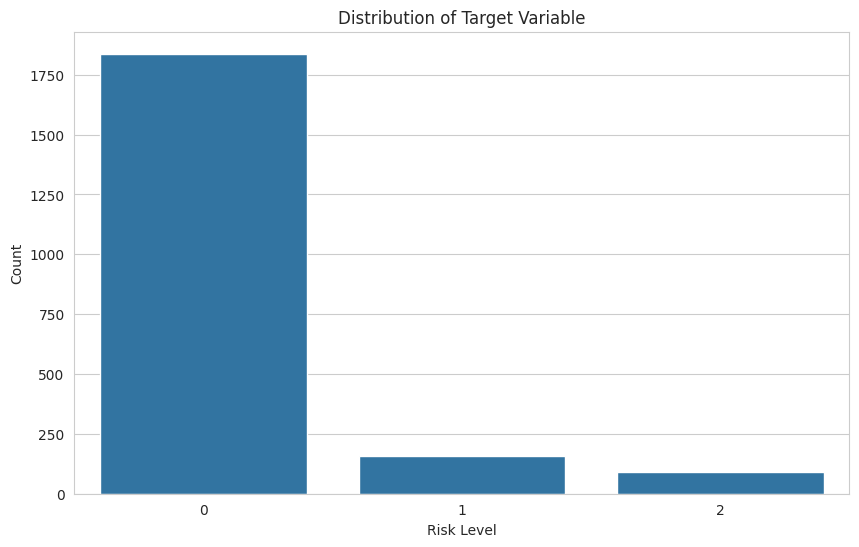

In [135]:
# Visualizing the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Risk Level')
plt.xticks(rotation=0)
plt.title('Distribution of Target Variable')
plt.xlabel('Risk Level')
plt.ylabel('Count')
plt.show()

In [136]:
# Displaying the dataset shape
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (1670, 4)
Shape of X_test: (418, 4)
Shape of y_train: (1670,)
Shape of y_test: (418,)


In [137]:
# Step 1: Check for class imbalance in the 'Risk Level' column
class_distribution = data['Risk Level'].value_counts()

# Print the distribution of classes
print("Class distribution in 'Risk Level':")
print(class_distribution)


Class distribution in 'Risk Level':
Risk Level
0    1838
1     158
2      92
Name: count, dtype: int64


Original dataset size: (2088, 4)
Resampled dataset size: (5514, 4)


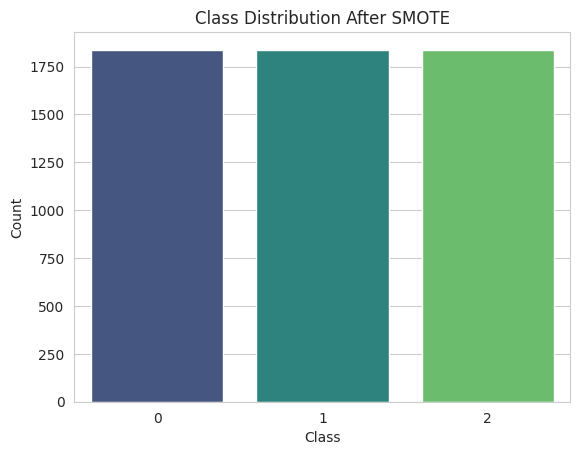

In [138]:
# Suppressing the FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Handling imbalanced dataset
# --- Convert 'Transaction Date' to numerical representation ---
# Option 1: Days since a reference date
# reference_date = X['Transaction Date'].min()
# X['Transaction Date'] = (X['Transaction Date'] - reference_date).dt.days

# Option 2: Ordinal encoding (if date order is important)
from sklearn.preprocessing import OrdinalEncoder

# Handle NaT values before fitting OrdinalEncoder
X['Transaction Date'] = pd.to_datetime(X['Transaction Date'], errors='coerce')  # Convert to datetime, NaT for errors
X['Transaction Date'] = X['Transaction Date'].fillna(X['Transaction Date'].min()) #Fill NaT with minimum date

encoder = OrdinalEncoder()
X['Transaction Date'] = encoder.fit_transform(X[['Transaction Date']])

# --- Apply SMOTE ---
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=1)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Original dataset size:", X.shape)
print("Resampled dataset size:", X_resampled.shape)

# Plotting class distribution after SMOTE
sns.countplot(x=y_resampled, palette="viridis")
plt.title("Class Distribution After SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [139]:
# Define the new folder path
folder_path = '/content/drive/MyDrive/DSGP_User/Pre Processed data'

# Define the file name for the saved dataset
file_name = 'preprocessed_stock_report 1.xlsx'

# Save the pre-processed DataFrame to the new folder
data.to_excel(os.path.join(folder_path, file_name), index=False)

print(f"Pre-processed dataset saved to: {os.path.join(folder_path, file_name)}")

Pre-processed dataset saved to: /content/drive/MyDrive/DSGP_User/Pre Processed data/preprocessed_stock_report 1.xlsx
